# Prediction diabetes readmission

## Business Understanding


I decided to work with this dataset since it represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. The integrity of this data could help me to solve a real-world problem using Data science.

 I’ll be using Machine Learning to predict whether a patient could be:
 
1. No readmission;
2. A readmission in less than 30 days (this situation is not good, because maybe
your treatment was not appropriate);
3. A readmission in more than 30 days (this one is not so good as well the last
one, however, the reason could be the state of the patient.

The analisys walks through the next steps:
 1. Data Understanding
 2. Data Exploration

## 1. Data Understanding

First, I'm going to start reading diabetes training data into a pandas dataframe called df_diabetes and importing the necessary dependecies needed in the analysis.

In [13]:
import pandas as pd
import utils.columns_utils as cu
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

df_diabetes = pd.read_csv("./resource/diabetic_data.csv", index_col='encounter_id')

Then checking data, it has been read properly: First five rows:

In [14]:
df_diabetes.head(5)

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,...,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,...,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [15]:
num_rows = df_diabetes.shape[0]
num_col = df_diabetes.shape[1]
print ("Number of columns :{} and rows:{} ".format(num_col, num_rows))

Number of columns :49 and rows:101766 


### 1.1 Checking Nullabilty

In this step, I want to be sure the data is clean (has no null values, etc).

In [16]:
cu.get_info_cleaing_process(df_diabetes)
print(f"Quantity null values (Nan or None): {df_diabetes.isnull().sum().sum()}\n")
df_diabetes.info()


Columns missing values
Series([], dtype: int64)
Quantity null values (Nan or None): 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures    

Note that the data doesn't have some missing values (Nan, null or none) 
in the samples in the previous figure. However, there are a lot of question marks "?", but I’ll skip that for now.

### 1.2 Knowing columns data type (Text - Quantitative):

In [17]:

print("Text columns:")
text_columns = cu.get_columns_type(df_diabetes.select_dtypes(include='object'))

print("Quantitative columns:")
quantitative_columns = cu.get_columns_type(df_diabetes.select_dtypes(exclude='object'))


Text columns:
		 race
		 gender
		 age
		 weight
		 payer_code
		 medical_specialty
		 diag_1
		 diag_2
		 diag_3
		 max_glu_serum
		 A1Cresult
		 metformin
		 repaglinide
		 nateglinide
		 chlorpropamide
		 glimepiride
		 acetohexamide
		 glipizide
		 glyburide
		 tolbutamide
		 pioglitazone
		 rosiglitazone
		 acarbose
		 miglitol
		 troglitazone
		 tolazamide
		 examide
		 citoglipton
		 insulin
		 glyburide-metformin
		 glipizide-metformin
		 glimepiride-pioglitazone
		 metformin-rosiglitazone
		 metformin-pioglitazone
		 change
		 diabetesMed
		 readmitted
Quantitative columns:
		 patient_nbr
		 admission_type_id
		 discharge_disposition_id
		 admission_source_id
		 time_in_hospital
		 num_lab_procedures
		 num_procedures
		 num_medications
		 number_outpatient
		 number_emergency
		 number_inpatient
		 number_diagnoses



### 1.3 Categorical variables analysis


Using the above text and quantitative columns,  I'm going to review all items in the list in order to select which features correspond to categorical variables.

In [18]:
p_var_cat = [ 'race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1',
		 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
		 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
         'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
		 'examide', 'citoglipton','insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
		 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
		 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
		 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency',
		 'number_inpatient', 'number_diagnoses']

df_diabetes[p_var_cat].astype('category')
print(df_diabetes[p_var_cat].nunique())

race                            6
gender                          3
age                            10
weight                         10
payer_code                     18
medical_specialty              73
diag_1                        717
diag_2                        749
diag_3                        790
max_glu_serum                   4
A1Cresult                       4
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  4
glimepiride                     4
acetohexamide                   2
glipizide                       4
glyburide                       4
tolbutamide                     2
pioglitazone                    4
rosiglitazone                   4
acarbose                        4
miglitol                        4
troglitazone                    2
tolazamide                      3
examide                         1
citoglipton                     1
insulin                         4
glyburide-metf

### Not Categorical Variables:

Remember Categorical variables must have a low number of categories .If the number of categories is big, the transformation could decrease the performance.The next feature list have a big number of categories per feature (>10), that is why, they aren't categorical variables.

```age, weight, payer_code, medical_specialty, Diag_1,Diag_2, Diag_3, patient_nbr, discharge_disposition_id, admission_source_id, time_in_hospital,num_lab_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses.```

 Even when the below features could be categorical variables, looking the accuracy once the prediction has been done using all the Diabetes medicines. They don't contribute nothing to the accurency score. In that order they aren't going to be take into account.
 

```'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
 'examide', 'citoglipton','insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
 'metformin-rosiglitazone', 'metformin-pioglitazone'```

###  Categorical Variables:

Once the categorical variable analysis process finished, I obtained the following list of Categorical Variables:

```'race', 'gender',  'change', 'diabetesMed', 'readmitted','admission_type_id','num_procedures'```

## 2. Data Exploration

The next step is explore the correlation of data and visualize it using a heatmap.

In [24]:
#readmitt convert N=0, >30=1, <30=2
df_diabetes ['readmitted_num'] = df_diabetes['readmitted'].str.slice(0, 1)
df_diabetes ['readmitted_num'] =  df_diabetes ['readmitted_num'].replace(['N'],0)
df_diabetes ['readmitted_num'] =  df_diabetes ['readmitted_num'].replace(['>'],1)
df_diabetes ['readmitted_num'] =  df_diabetes ['readmitted_num'].replace(['<'],2)
df_diabetes.drop(['readmitted'],axis=1, inplace=True)

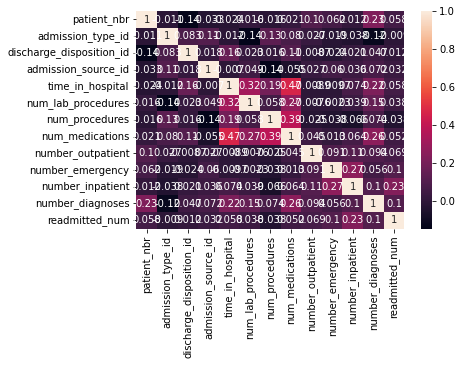

In [25]:
numeric_dtypes_corr = df_diabetes.corr()
sns.heatmap(numeric_dtypes_corr, annot=True)
plt.show()

In the above heatmap, brighter colors indicate more correlation between the next features: patient_nbr, time_in_hospital, num_lab_procedures, num_procedures, num_medications

In [ ]:


print (numeric_dtypes_corr)

In [32]:
pd.crosstab([df_diabetes.gender,df_diabetes.admission_type_id],[df_diabetes.diabetesMed, df_diabetes.readmitted],margins=True).style.background_gradient(cmap='pink_r')

In [ ]:
#NOrmaliza?
df_diabetes_target_prediction_variables = pd.get_dummies(df_diabetes[[ 'race', 'gender',  'change', 'diabetesMed', 'readmitted', 'num_procedures',
		 'admission_type_id', 'readmitted_num','num_lab_procedures','time_in_hospital','num_procedures', 'num_medications', 'num_lab_procedures', 'number_diagnoses']])
print(df_diabetes_target_prediction_variables.head())

x = df_diabetes_target_prediction_variables
y = df_diabetes_target_prediction_variables['readmitted_num']

x.drop(['readmitted_num'],axis=1, inplace=True)


# Learning process
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state = 0)
lm_model = KNeighborsClassifier(n_neighbors=3)
lm_model.fit(X_train, y_train)

y_pred = lm_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))